In [11]:
import os
import json
import jsonlines
from collections import defaultdict, Counter

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import networkx as nx
import community.community_louvain as community
from sklearn.cluster import AffinityPropagation

In [12]:
NUM_FORMATS = 128

In [13]:
result_dir = "../../../results"

In [14]:
model_name = "Llama-3.1-8B-Instruct"
# model_name = "gpt-4o-2024-11-20"
dataset_name = "CommonsenseQA"
prompting_strategy = "zero-shot"

output_dir = f"{result_dir}/{dataset_name}/{model_name}"

# 1: average distance matrices
output_predictions_path = os.path.join(output_dir, f"{prompting_strategy}_ext_score.json")
distance_matrix = np.zeros((NUM_FORMATS, NUM_FORMATS))
with open(output_predictions_path, "r") as fin:
    score = json.load(fin)
    for i in range(NUM_FORMATS):
        for j in range(i+1, NUM_FORMATS):
            distance_matrix[i][j] = 1.0 - score["consistency"][f"{i}_{j}"]
            distance_matrix[j][i] = 1.0 - score["consistency"][f"{i}_{j}"]

# 2: sample-wise distance matrices
output_predictions_path = os.path.join(output_dir, f"{prompting_strategy}_ext_predictions.jsonl")
# distance_matrix = []
major, minor = defaultdict(int), defaultdict(int)
all_predictions = []
consistent, inconsistent = 0, 0
with jsonlines.open(output_predictions_path) as fin:
    for example in fin.iter():
        # Measure consistency score
        example_consistency = []
        example_predictions = []
        for i in range(NUM_FORMATS):
            example_consistency_i = []
            example_predictions.append(example["predictions"][str(i)])
            for j in range(NUM_FORMATS):
                ### Compute consistency
                consistency = (example["predictions"][str(i)] == example["predictions"][str(j)])*1.0
                ### Save consistency scores for an example
                example_consistency_i.append(consistency)
            example_consistency.append(example_consistency_i)
        if len(set(example_predictions)) > 1:
            inconsistent += 1
        elif len(set(example_predictions)) == 1:
            consistent += 1
        else:
            raise Exception
        # distance_matrix.append(example_consistency)
        # Majority voting
        ### Compute majority voting prediction and accuracy
        prediction_counts = Counter(example_predictions)
        max_count = prediction_counts.most_common(1)[0][1]
        majority_predictions = []
        for prediction, count in prediction_counts.items():
            if count >= max_count:
                majority_predictions.append(prediction)
        for i in range(NUM_FORMATS):
            if example_predictions[i] in majority_predictions:
                major[i] += 1
            else:
                minor[i] += 1
        all_predictions.append(example_predictions)
all_predictions = np.array(all_predictions)
# distance_matrix = np.array(distance_matrix, dtype=np.float64)

In [15]:
consistent, inconsistent, consistent + inconsistent, inconsistent / (consistent + inconsistent)

(624, 353, 977, 0.36131013306038895)

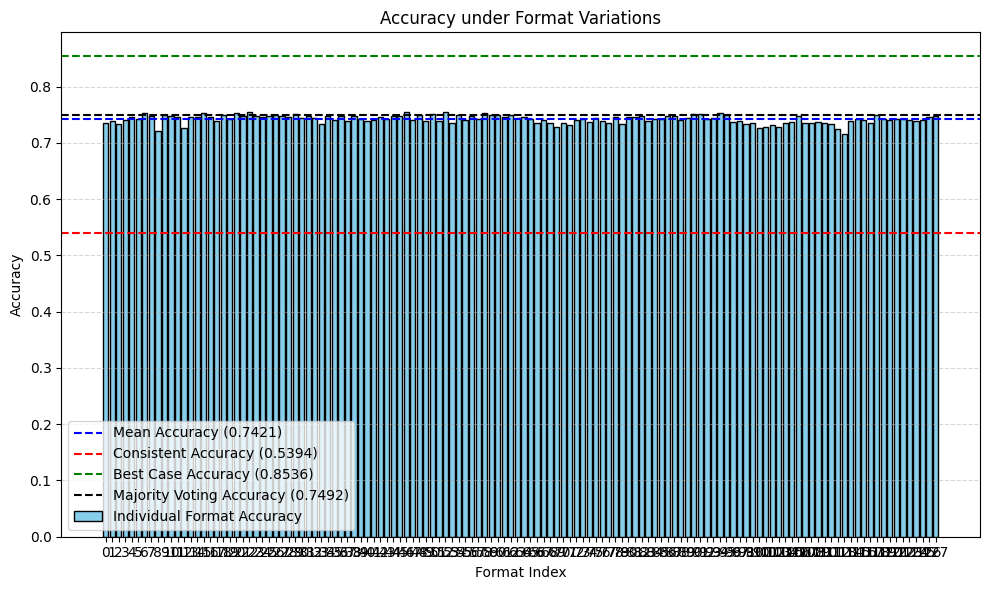

In [16]:
model_results = score

# Prepare data for visualization
x_labels = [str(format_type) for format_type in range(NUM_FORMATS)]
accuracy_values = [model_results["accuracy"][str(format_type)] for format_type in range(NUM_FORMATS)]

# Plot settings
plt.figure(figsize=(10, 6))

# Create the bar chart
plt.bar(x_labels, accuracy_values, color='skyblue', edgecolor='black', label='Individual Format Accuracy')

# Add dashed lines for overall metrics
plt.axhline(y=model_results["accuracy"]["mean"], color='blue', linestyle='--', label=f'Mean Accuracy ({model_results["accuracy"]["mean"]:.4f})')
plt.axhline(y=model_results["accuracy"]["min"], color='red', linestyle='--', label=f'Consistent Accuracy ({model_results["accuracy"]["min"]:.4f})')
plt.axhline(y=model_results["accuracy"]["max"], color='green', linestyle='--', label=f'Best Case Accuracy ({model_results["accuracy"]["max"]:.4f})')
plt.axhline(y=model_results["accuracy"]["majority_voting"], color='black', linestyle='--', label=f'Majority Voting Accuracy ({model_results["accuracy"]["majority_voting"]:.4f})')

# Add chart details
plt.title("Accuracy under Format Variations")
plt.xlabel("Format Index")
plt.ylabel("Accuracy")
# plt.ylim(0.6, 0.85)
plt.xticks(ticks=range(len(x_labels)), labels=x_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

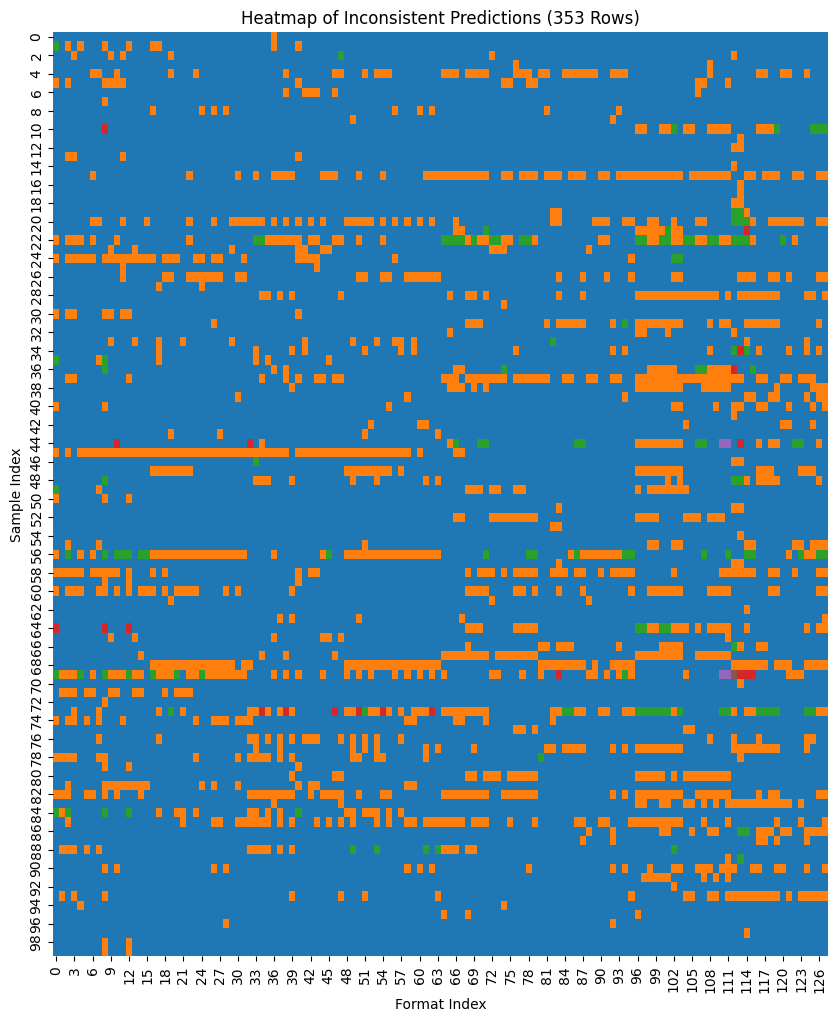

In [17]:
num_samples_for_viz = 100

# Step 1: Identify inconsistent rows (rows where at least two formats differ)
inconsistent_mask = np.any(all_predictions != all_predictions[:, 0][:, None], axis=1)
inconsistent_rows = all_predictions[inconsistent_mask]  # Filter inconsistent samples

# # Step 2: Convert characters to numerical values
# unique_chars = np.unique(inconsistent_rows)
# char_to_num = {char: i for i, char in enumerate(unique_chars)}
# numerical_array = np.vectorize(char_to_num.get)(inconsistent_rows)

# # Step 3: Define color mapping
# cmap = ListedColormap(sns.color_palette("tab10", len(unique_chars)))

# Step 2: Convert characters to sample-wise sorted indices
def map_sample_wise(row):
    char_counts = Counter(row)  # Count occurrences in this row
    sorted_chars = [char for char, _ in sorted(char_counts.items(), key=lambda x: -x[1])]  # Sort descending
    char_to_num = {char: i for i, char in enumerate(sorted_chars)}  # Assign 0, 1, 2 based on frequency
    return np.array([char_to_num[char] for char in row])  # Convert row

# Apply mapping row-wise
numerical_array = np.array([map_sample_wise(row) for row in inconsistent_rows])

# Step 3: Define color mapping
num_unique = np.max(numerical_array) + 1  # Get the number of unique mapped values
cmap = ListedColormap(sns.color_palette("tab10", num_unique))

# Step 4: Plot the filtered heatmap
plt.figure(figsize=(10, min(12, num_samples_for_viz / 4)))  # Dynamically adjust height
# sns.heatmap(numerical_array[:num_samples_for_viz], cmap=cmap, cbar=False, linewidths=0, annot=inconsistent_rows[:num_samples_for_viz], fmt="s")
sns.heatmap(numerical_array[:num_samples_for_viz], cmap=cmap, cbar=False, linewidths=0)

# Add title and labels
plt.title(f"Heatmap of Inconsistent Predictions ({len(inconsistent_rows)} Rows)")
plt.xlabel("Format Index")
plt.ylabel("Sample Index")
plt.show()

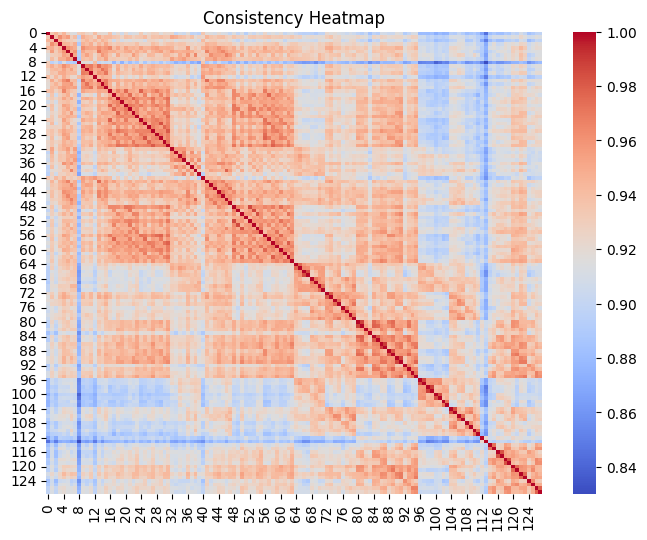

In [18]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sorted_matrix = 1 - distance_matrix

# Plot heatmap with cluster boundaries
plt.figure(figsize=(8, 6))
# ax = sns.heatmap(sorted_matrix, annot=True, cmap="coolwarm", fmt=".3f")
ax = sns.heatmap(sorted_matrix, cmap="coolwarm")

plt.title("Consistency Heatmap")
plt.show()

Cluster assignments: [ 1  0  0  0  2  2  5  4  1  2  2  2  1  2  2  2  3  6  3  3  3  6  3  3
  3  3  3  3  3  3  3  3  4  4  4  4  5  4  5  4  1  2  5  5  2  2  5  5
  3  6  3  6  3  6  5  6  3  6  3  3  3  6  3  3  7  7  7  7  8  8  8  8
  9  9 10 10  9 10 10 10 11 11 12 12 11 11 12 12 11 11 12 12 11 11 20 12
 14 13 13 13 14 14 13 13 15 15 10 10 15 15 16 16 17 18 20 20 19 19 20 20
 11 11 12 12 19 11 20 20]


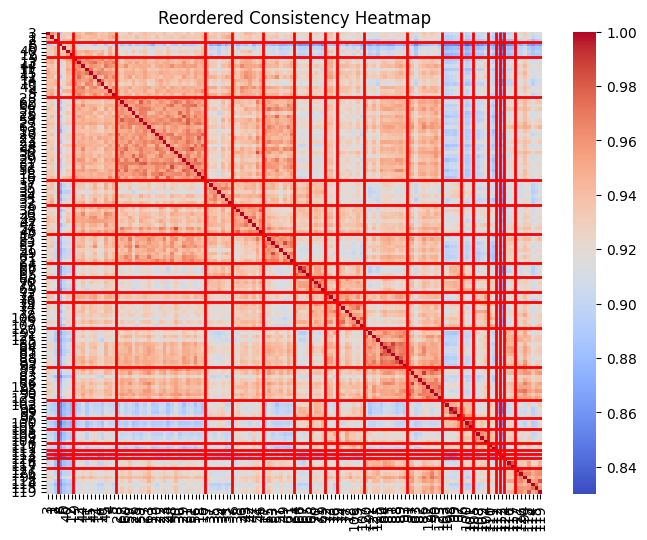

In [19]:
# Apply affinity propagation clustering
affinity_model = AffinityPropagation(affinity="precomputed")
labels = affinity_model.fit_predict(-distance_matrix)  # Negate distances for similarity-based clustering

print("Cluster assignments:", labels)

# Assume `labels` contains cluster assignments (e.g., from Spectral Clustering)
sorted_indices = np.argsort(labels)  # Reorder by cluster
sorted_matrix = 1 - distance_matrix[sorted_indices][:, sorted_indices]

# Find cluster boundaries
cluster_boundaries = np.where(np.diff(np.sort(labels)))[0] + 1

# Plot heatmap with cluster boundaries
plt.figure(figsize=(8, 6))
# ax = sns.heatmap(sorted_matrix, annot=True, cmap="coolwarm", xticklabels=sorted_indices, yticklabels=sorted_indices, fmt=".3f")
ax = sns.heatmap(sorted_matrix, cmap="coolwarm", xticklabels=sorted_indices, yticklabels=sorted_indices)

# Draw lines separating clusters
for boundary in cluster_boundaries:
    ax.hlines(boundary, *ax.get_xlim(), colors="red", linewidth=2)
    ax.vlines(boundary, *ax.get_ylim(), colors="red", linewidth=2)

plt.title("Reordered Consistency Heatmap")
plt.show()


In [20]:
average_distance = np.round(distance_matrix.sum(axis=1) / (NUM_FORMATS-1) * 100, 2)
average_similarity = np.round((((1 - distance_matrix).sum(axis=1)) - 1) / (NUM_FORMATS-1) * 100, 2)

print("*"*95)
print(f"Format index\tMajority cases\tMinority cases\tAverage distance\tAverage similarity")
print("*"*95)
for i in range(NUM_FORMATS):
    print(f"{i}\t\t{major[i]}\t\t{minor[i]}\t\t{average_distance[i]:.2f}\t\t\t{average_similarity[i]:.2f}")
print("*"*95)

print("*"*95)
print(f"Format index\t\tAccuracy")
for i in score["accuracy"]:
    if i in ["min", "max"]:
        continue
    if "major" in i:
        print(f"{i}\t\t{score['accuracy'][i]}")
    else:
        print(f"{i}\t\t\t{score['accuracy'][i]}")
print("*"*95)

***********************************************************************************************
Format index	Majority cases	Minority cases	Average distance	Average similarity
***********************************************************************************************
0		901		76		9.46			90.54
1		926		51		7.59			92.41
2		904		73		8.89			91.11
3		929		48		7.47			92.53
4		940		37		6.57			93.43
5		936		41		6.76			93.24
6		928		49		6.97			93.03
7		931		46		7.17			92.83
8		874		103		11.92			88.08
9		932		45		7.36			92.64
10		919		58		7.66			92.34
11		933		44		7.35			92.65
12		909		68		8.92			91.08
13		939		38		6.72			93.28
14		923		54		7.27			92.73
15		941		36		6.49			93.51
16		932		45		6.97			93.03
17		930		47		7.21			92.79
18		937		40		6.63			93.37
19		936		41		6.99			93.01
20		931		46		6.96			93.04
21		936		41		6.68			93.32
22		934		43		6.70			93.30
23		940		37		6.31			93.69
24		930		47		7.05			92.95
25		932		45		6.86			93.14
26		929		48		7.04			92.96
27		944		33		6.23			93.77
28		933		

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0}


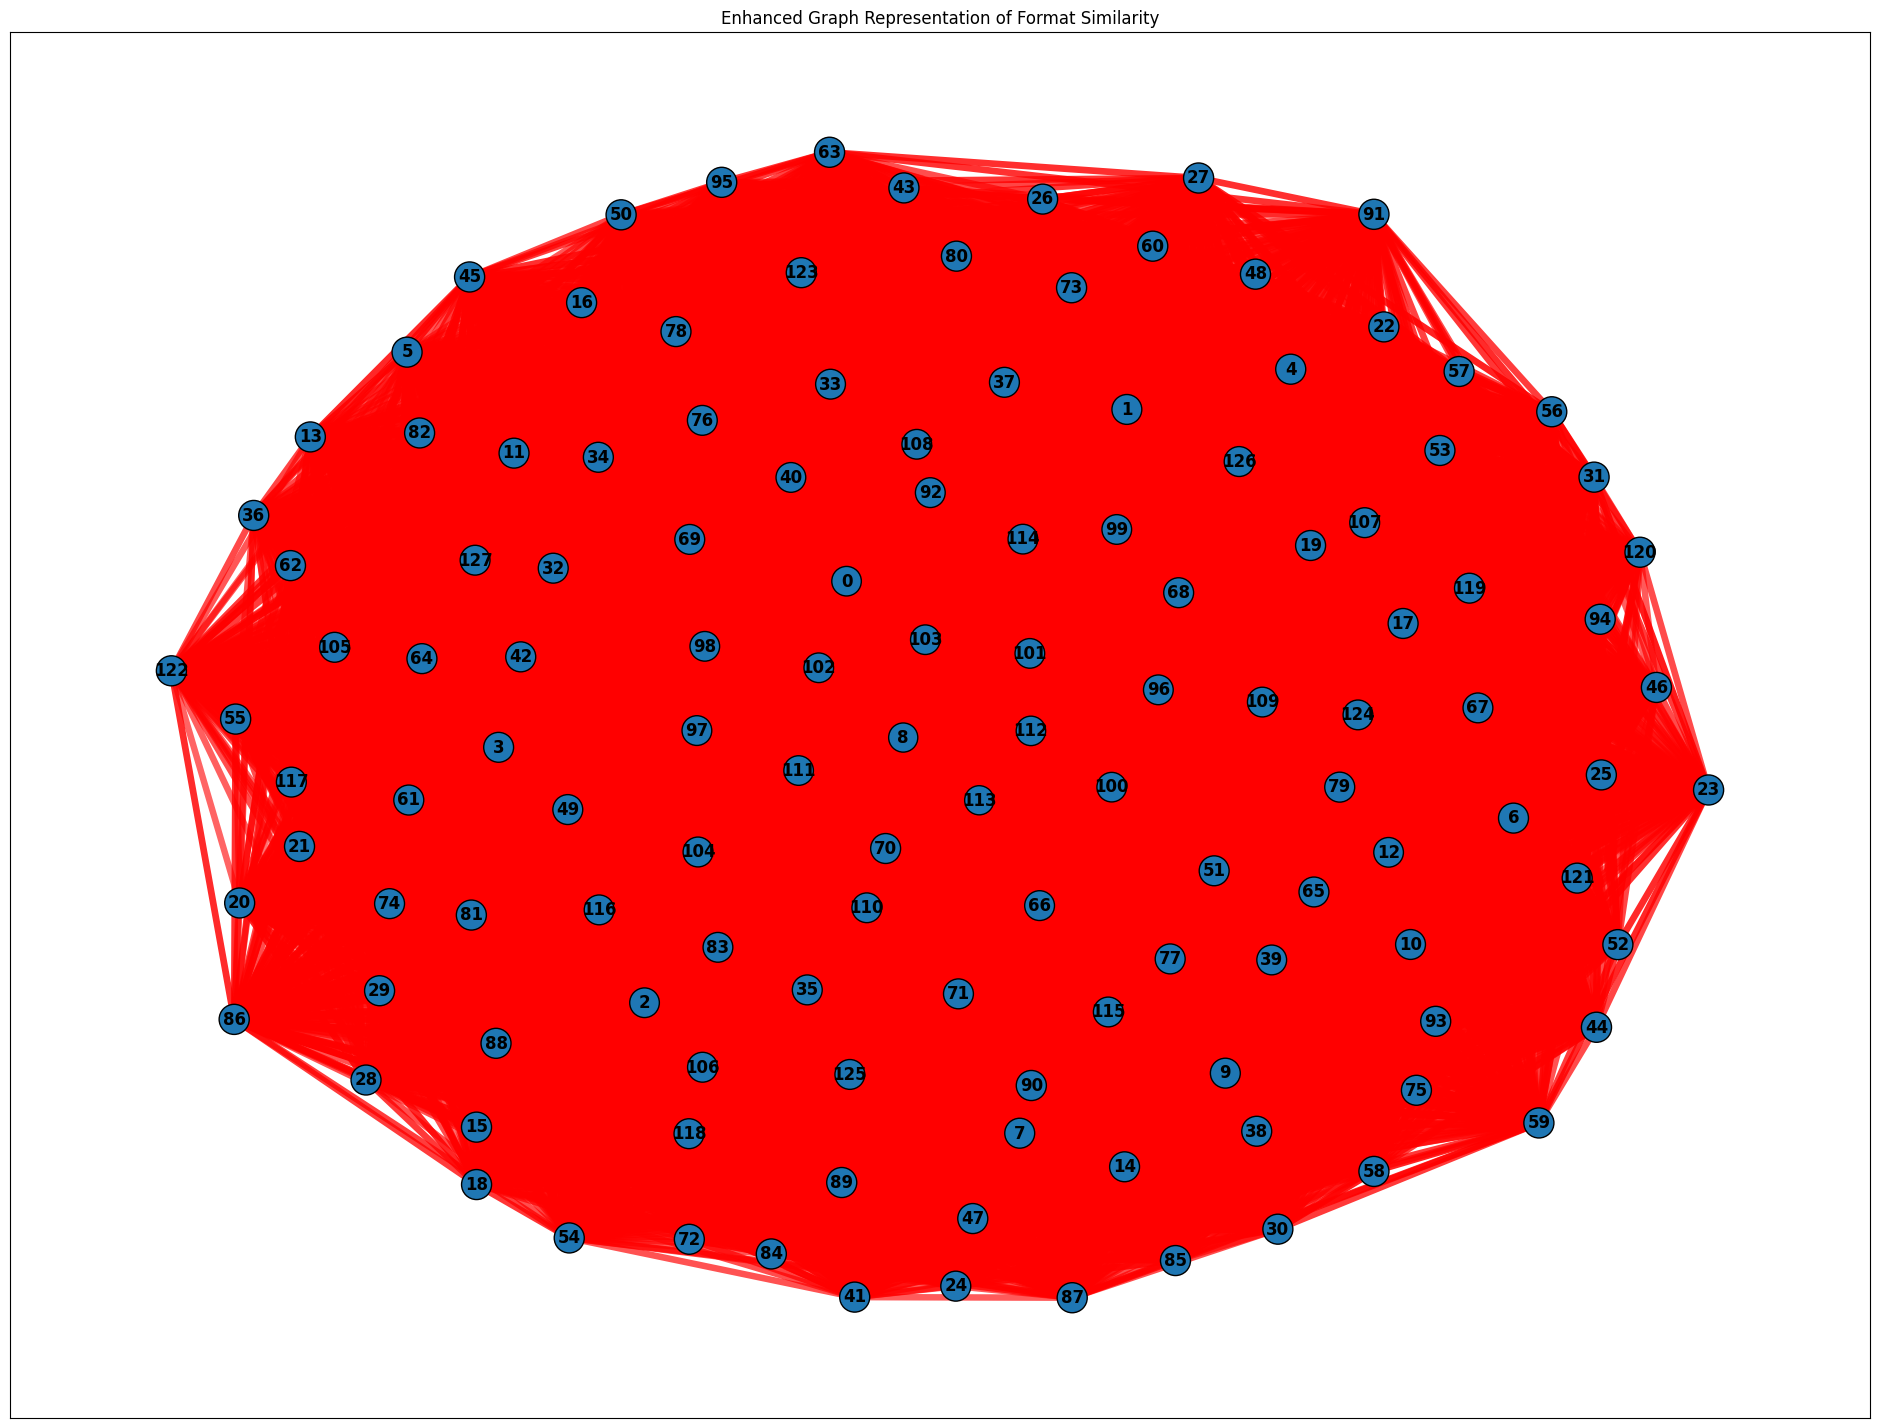

In [21]:
similarity_matrix = 1 - distance_matrix

# Create a graph
G = nx.Graph()

# Add nodes (formats)
num_formats = similarity_matrix.shape[0]
for i in range(num_formats):
    G.add_node(i)

# Convert similarity to distance (edge length)
for i in range(num_formats):
    for j in range(i + 1, num_formats):  
        distance = 1 - similarity_matrix[i, j]  # Higher similarity → Shorter distance
        G.add_edge(i, j, weight=distance, similarity=similarity_matrix[i, j])  # Store similarity for visualization

# Apply community detection (Louvain clustering)
partition = community.best_partition(G)
print(partition)

# Assign colors based on detected communities
unique_clusters = set(partition.values())
colors = plt.get_cmap("tab10", len(unique_clusters))
node_colors = [colors(partition[n]) for n in G.nodes()]

# Compute node sizes (sum of similarity scores)
node_sizes = [(sum(similarity_matrix[i])-1)/(NUM_FORMATS-1) * 500 for i in range(num_formats)]  # Scale for visibility

# Compute edge thickness based on similarity
edge_weights = [5 * (1 - G[u][v]["weight"]) for u, v in G.edges()]  # Convert back to similarity

# Compute transparency (weaker edges = more transparent)
edge_alpha = [G[u][v]["similarity"] for u, v in G.edges()]  # Use similarity directly
edge_alpha = [(w - min(edge_alpha)) / (max(edge_alpha) - min(edge_alpha) + 1e-6) for w in edge_alpha]  # Normalize

# Compute force-directed layout (closer nodes = higher similarity)
pos = nx.spring_layout(G, seed=42, weight="weight")  # Distance-based placement

# Draw edges with varying thickness & transparency
plt.figure(figsize=(24, 18))
for (u, v), alpha, width in zip(G.edges(), edge_alpha, edge_weights):
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width, alpha=alpha, edge_color="red")

# Draw nodes with color and size variation
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors="black")

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")

# Show graph
plt.title("Enhanced Graph Representation of Format Similarity")
plt.show()
